In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def RadixSort(A, bits_per_pass = 4, max_bits = 32):
    iters = max_bits // bits_per_pass
    group_size = 128
    histogram_size = 2 ** bits_per_pass

    def GetBits(A, i):
        return (A >> (i * bits_per_pass)) & (histogram_size - 1)
    
    B = tf.buffer(A.shape, A.type)
    with tf.loop(iters // 2) as iter:
        def SortIteration(A, B, iter):
            grouped = tf.split_dim(GetBits(A, iter), group_size)
            g, e, i = tf.indices([grouped.shape[0], grouped.shape[1], histogram_size])
            is_bit = tf.select((grouped[g, e] == i) & ((g*group_size + e) < A.shape[0]), 1, 0)
            group_histogram = tf.sum(is_bit, axis = 1)
            group_histogram_scan = tf.prefix_sum(group_histogram, axis = 0)
            i, = tf.indices([histogram_size])
            total_bit_histogram = tf.prefix_sum(group_histogram_scan[group_histogram_scan.shape[0] - 1, i])
            with tf.kernel(grouped.shape) as (g, e):
                element = g * group_size + e
                with tf.if_cond(element < A.shape[0]):
                    old = A[element]
                    bit = GetBits(old, iter)
                    total_offset = tf.select(g == 0, 0, group_histogram_scan[g - 1, bit]) + tf.select(bit == 0, 0, total_bit_histogram[bit - 1])
                    with tf.loop(e) as j:
                        total_offset.val += tf.int(grouped[g, j] == bit)
                    B[total_offset] = old

        SortIteration(A, B, 2 * iter)
        SortIteration(B, A, 2 * iter + 1)

    return A

def Sort():
    data = tf.input([-1], tf.int32)
    sorted = RadixSort(data)
    return sorted

sort_program = tf.compile(Sort)

TensorFrost module loaded!
Sort:
  Kernel count: 8
  Intermediate buffers: 7
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 778
  IR Compile time: 10.379000 ms
  Steps time: 1613.010132 ms



Error:  0


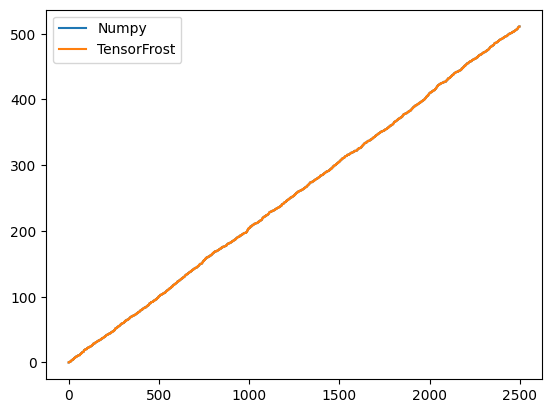

In [2]:
# Generate some random data to scan (ints between 0 and 10)
data = np.random.randint(0, 512, 2500)
data_tf = tf.tensor(data)
sort_tf = sort_program(data_tf)

# do scan in numpy
sort_np  = np.sort(data)

#print error
print("Error: ", np.max(np.abs(sort_tf.numpy - sort_np)))

# Plot the results
plt.plot(sort_np, label = "Numpy")
plt.plot(sort_tf.numpy, label = "TensorFrost")
plt.legend()
plt.show()